# Options Buying Model Analysis
## Comprehensive Analysis Using Bollinger Bands, GARCH, Markov Models, and OHLC Forecasting

This notebook integrates multiple forecasting components to create an options buying model:
- **Bollinger Bands**: Technical indicator for price volatility and position
- **GARCH Model**: Volatility forecasting with heteroskedasticity
- **Markov Chain**: State transition modeling for BB positions
- **OHLC Forecasting**: Open, High, Low, Close price predictions
- **Options Strategies**: Specific options trading recommendations

In [1]:
print("## Setup and Imports")

## Setup and Imports


In [2]:
import sys, os
sys.path.append(os.path.abspath('../src'))

# Load environment variables
from dotenv import load_dotenv
load_dotenv('../.env')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Import our modules
from data.preprocess import preprocess_price_matrix
from data.loader import get_multiple_stocks
from models.svd import rolling_svd_factors


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
from data.loader import get_multiple_stocks
from indicators.bollinger_bands import calculate_bollinger_bands, plot_bollinger_bands, get_bb_regime
from models.garch_volatility import create_volatility_model, plot_volatility_forecast, plot_ma_forecast
from models.markov_bb import BollingerBandMarkovModel
from models.ohlc_forecasting import OHLCForecaster
from models.options_strategies import OptionsStrategyRecommender

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ All modules imported successfully!")

✅ All modules imported successfully!


In [3]:
print("## 1. Data Loading and Preparation")

## 1. Data Loading and Preparation


In [4]:
# Load data for ALL stocks first for global model training
symbols = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA', 'AMZN', 'META', 'NFLX', 'CRM', 'ADBE']
selected_symbol = 'AAPL'  # Primary analysis symbol

print(f"Loading stock data for: {', '.join(symbols)}")

# Load stock data for all symbols
try:
    # Note: get_multiple_stocks loads data for all available symbols in the cache
    stock_data = get_multiple_stocks(selected_symbol, update=False, rate_limit=5.0)
    
    print(f"✅ Successfully loaded data for {len(stock_data['Close'].columns)} stocks")
    available_symbols = [col for col in stock_data['Close'].columns if col != 'date']
    print(f"📈 Available symbols: {available_symbols}")
    print(f"📊 Date range: {stock_data['Close'].index[0].strftime('%Y-%m-%d')} to {stock_data['Close'].index[-1].strftime('%Y-%m-%d')}")
    print(f"📈 Total observations per stock: {len(stock_data['Close'])}")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

Loading stock data for: AAPL, MSFT, GOOGL, TSLA, NVDA, AMZN, META, NFLX, CRM, ADBE
Loading cached data from /mnt/a61cc0e8-1b32-4574-a771-4ad77e8faab6/conda/technical_dashboard/cache/stock_data.pkl
✅ Successfully loaded data for 517 stocks
📈 Available symbols: ['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APO', 'APP', 'APTV', 'ARE', 'ARM', 'ASML', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZN', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBY', 'BDX', 'BEN', 'BG', 'BIIB', 'BK', 'BKNG', 'BKR', 'BLDR', 'BLK', 'BMY', 'BR', 'BRO', 'BSX', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCEP', 'CCI', 'CCL', 'CDNS', 'CDW', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC'

In [5]:
# Prepare Bollinger Bands data for ALL stocks (Global Model Training)
from indicators.bollinger_bands import calculate_bollinger_bands

print("🌍 PREPARING DATA FOR GLOBAL MODEL TRAINING")
print("=" * 60)

all_stock_bb_data = {}
bb_window = 20
bb_std = 2.0

print(f"Calculating Bollinger Bands for all stocks (window={bb_window}, std={bb_std})...")

# Process each stock in the dataset
for symbol in available_symbols:
    try:
        # Get OHLC data for this stock
        stock_df = pd.DataFrame({
            'Open': stock_data['Open'][symbol],
            'High': stock_data['High'][symbol], 
            'Low': stock_data['Low'][symbol],
            'Close': stock_data['Close'][symbol]
        }).dropna()
        
        if len(stock_df) < 50:  # Skip stocks with insufficient data
            print(f"⚠️  Skipping {symbol}: insufficient data ({len(stock_df)} obs)")
            continue
        
        # Calculate Bollinger Bands for this stock
        bb_data_stock = calculate_bollinger_bands(stock_df['Close'], window=bb_window, num_std=bb_std)
        
        # Calculate trend classification (needed for Markov model)
        ma_series = bb_data_stock['MA']
        ma_slope = ma_series.diff(5) / 5  # 5-day slope
        
        # Apply 7-trend classification thresholds
        trend = np.select([
            ma_slope > 0.05,   # Parabolic up
            ma_slope > 0.025,  # Strong up  
            ma_slope > 0.008,  # Up
            ma_slope < -0.05,  # Parabolic down
            ma_slope < -0.025, # Strong down
            ma_slope < -0.008, # Down
        ], [
            'parabolic_up',
            'strong_up', 
            'up',
            'parabolic_down',
            'strong_down',
            'down'
        ], default='ranging')
        
        # Prepare data with ALL required columns (PRESERVE OHLC DATA!)
        all_stock_bb_data[symbol] = pd.DataFrame({
            'Open': stock_df['Open'],          # ✅ Keep Open data
            'High': stock_df['High'],          # ✅ Keep High data
            'Low': stock_df['Low'],            # ✅ Keep Low data
            'Close': stock_df['Close'],        # ✅ Keep Close data
            'BB_Position': bb_data_stock['BB_Position'],
            'MA': bb_data_stock['MA'],
            'BB_Width': bb_data_stock['BB_Width'],
            'Trend': trend                     # ✅ Add trend classification
        }).dropna()
        
        print(f"✅ {symbol}: {len(all_stock_bb_data[symbol])} observations")
        
    except Exception as e:
        print(f"❌ Error processing {symbol}: {e}")
        continue

print(f"\n📈 Successfully prepared data for {len(all_stock_bb_data)} stocks")
print(f"📊 Stock list: {list(all_stock_bb_data.keys())}")

# Store total observations for global model
total_global_observations = sum(len(data) for data in all_stock_bb_data.values())
print(f"🌍 Total observations for global model: {total_global_observations:,}")

# Verify OHLC data is preserved
sample_stock = list(all_stock_bb_data.keys())[0]
sample_columns = list(all_stock_bb_data[sample_stock].columns)
print(f"✅ Verified OHLC data preserved - Sample columns: {sample_columns}")

🌍 PREPARING DATA FOR GLOBAL MODEL TRAINING
Calculating Bollinger Bands for all stocks (window=20, std=2.0)...
✅ A: 1237 observations
✅ AAPL: 1237 observations
✅ ABBV: 1237 observations
✅ ABNB: 1146 observations
✅ ABT: 1237 observations
✅ ACGL: 1237 observations
✅ ACN: 1237 observations
✅ ADBE: 1237 observations
✅ ADI: 1237 observations
✅ ADM: 1237 observations
✅ ADP: 1237 observations
✅ ADSK: 1237 observations
✅ AEE: 1237 observations
✅ AEP: 1237 observations
✅ AES: 1237 observations
✅ AFL: 1237 observations
✅ AIG: 1237 observations
✅ AIZ: 1237 observations
✅ AJG: 1237 observations
✅ AKAM: 1237 observations
✅ ALB: 1237 observations
✅ ALGN: 1237 observations
✅ ALL: 1237 observations
✅ ALLE: 1237 observations
✅ AMAT: 1237 observations
✅ AMCR: 1237 observations
✅ AMD: 1237 observations
✅ AME: 1237 observations
✅ AMGN: 1237 observations
✅ AMP: 1237 observations
✅ AMT: 1237 observations
✅ AMZN: 1237 observations
✅ ANET: 1237 observations
✅ ANSS: 1236 observations
✅ AON: 1237 observations
✅ 

In [6]:
# Train Global Multi-Stock Bayesian Markov Model with 7 Trend-Specific Priors
from models.markov_bb import MultiStockBBMarkovModel

print("🚀 TRAINING GLOBAL MULTI-STOCK BAYESIAN MARKOV MODEL")
print("=" * 60)

# Initialize the enhanced model with 7 trend states (very sensitive thresholds for more data)
multi_stock_model = MultiStockBBMarkovModel(
    n_states=5,
    parabolic_up_thresh=0.05,   # >5% slope = Parabolic Up
    strong_up_thresh=0.025,     # 2.5-5% slope = Strong Up
    up_thresh=0.008,            # 0.8-2.5% slope = Up  
    down_thresh=-0.008,         # -0.8% to 0.8% slope = Ranging
    strong_down_thresh=-0.025,  # -2.5% to -0.8% slope = Down
    parabolic_down_thresh=-0.05 # <-5% slope = Parabolic Down
)

print(f"📊 Model Configuration (Maximum Sensitivity):")
print(f"  States: {multi_stock_model.n_states}")
print(f"  State Labels: {['Extreme_Low', 'Low', 'Middle', 'High', 'Extreme_High']}")
print(f"  Trend Thresholds (7 Trend States - Maximum Sensitivity):")
print(f"    Parabolic_up: >{multi_stock_model.parabolic_up_thresh:.1%}")
print(f"    Strong_up: >{multi_stock_model.strong_up_thresh:.1%} to {multi_stock_model.parabolic_up_thresh:.1%}")
print(f"    Up: >{multi_stock_model.up_thresh:.1%} to {multi_stock_model.strong_up_thresh:.1%}")
print(f"    Ranging: {multi_stock_model.down_thresh:.1%} to {multi_stock_model.up_thresh:.1%}")
print(f"    Down: {multi_stock_model.strong_down_thresh:.1%} to {multi_stock_model.down_thresh:.1%}")
print(f"    Strong_down: {multi_stock_model.parabolic_down_thresh:.1%} to {multi_stock_model.strong_down_thresh:.1%}")
print(f"    Parabolic_down: <{multi_stock_model.parabolic_down_thresh:.1%}")

# Step 1: Learn TREND-SPECIFIC global priors from ALL stocks (7 trends)
print(f"\n🌍 STEP 1: Learning 7 Trend-Specific Global Priors from All Stocks")
print("-" * 50)

global_trend_priors = multi_stock_model.fit_global_prior(
    all_stock_bb_data, 
    alpha_global=1.0  # Lower alpha = less smoothing for global prior
)

print(f"\n✅ 7 Trend-Specific Global Priors Training Complete!")
print(f"📊 Number of trend-specific priors: {len(global_trend_priors)}")
print(f"🏷️  Trend states: {list(global_trend_priors.keys())}")

# Display trend-specific global transition matrices
print(f"\n📈 7 Trend-Specific Global Transition Matrices:")
for trend, prior_matrix in global_trend_priors.items():
    print(f"\n🎯 {trend.upper()} TREND Global Prior:")
    if trend in multi_stock_model.global_trend_models:
        state_labels = multi_stock_model.global_trend_models[trend].state_labels
        trend_df = pd.DataFrame(
            prior_matrix, 
            index=state_labels,
            columns=state_labels
        ).round(3)
        print(trend_df)
    else:
        print("  Matrix not available")

🚀 TRAINING GLOBAL MULTI-STOCK BAYESIAN MARKOV MODEL
📊 Model Configuration (Maximum Sensitivity):
  States: 5
  State Labels: ['Extreme_Low', 'Low', 'Middle', 'High', 'Extreme_High']
  Trend Thresholds (7 Trend States - Maximum Sensitivity):
    Parabolic_up: >5.0%
    Strong_up: >2.5% to 5.0%
    Up: >0.8% to 2.5%
    Ranging: -0.8% to 0.8%
    Down: -2.5% to -0.8%
    Strong_down: -5.0% to -2.5%
    Parabolic_down: <-5.0%

🌍 STEP 1: Learning 7 Trend-Specific Global Priors from All Stocks
--------------------------------------------------
🌍 Learning TREND-SPECIFIC global priors from all stocks...
  📊 Processed A: 1237 observations
  📊 Processed AAPL: 1237 observations
  📊 Processed ABBV: 1237 observations
  📊 Processed ABNB: 1146 observations
  📊 Processed ABT: 1237 observations
  📊 Processed ACGL: 1237 observations
  📊 Processed ACN: 1237 observations
  📊 Processed ADBE: 1237 observations
  📊 Processed ADI: 1237 observations
  📊 Processed ADM: 1237 observations
  📊 Processed ADP: 1237

In [7]:
# Train Stock-Specific Models using 7 Trend-Specific Global Priors
print("🏢 TRAINING STOCK-SPECIFIC MODELS WITH 7 TREND-SPECIFIC GLOBAL PRIORS")
print("=" * 60)

# Step 2: Fit stock-specific models using 7 trend-specific global priors
print(f"🏢 STEP 2: Fitting Stock-Specific Models with 7 Trend-Specific Global Priors")
print("-" * 50)

multi_stock_model.fit_stock_models(
    all_stock_bb_data,
    alpha_stock=5.0  # Higher alpha = more weight to global prior
)

# Step 3: Analyze individual stock models with new 7-trend structure
print(f"\n📊 STEP 3: Stock-Specific Model Analysis with 7 Trend-Specific Priors")
print("-" * 50)

# Get enhanced model summary
model_summary = multi_stock_model.get_model_summary()

print(f"🌍 Global Models Status:")
print(f"  Unified Global Model: {'✅ Fitted' if model_summary['global_models']['unified_global']['fitted'] else '❌ Not Fitted'}")
print(f"  7 Trend-Specific Global Models:")
for trend, trend_info in model_summary['global_models']['trend_specific_globals'].items():
    status = "✅ Fitted" if trend_info['fitted'] else "❌ Not Fitted"
    print(f"    🎯 {trend}: {status}")

print(f"\n🏢 Stock-Specific Models Summary:")

for symbol, stock_info in model_summary['stock_models'].items():
    print(f"  📈 {symbol}:")
    print(f"    📊 Observations: {stock_info['total_observations']}")
    print(f"    🎯 Current Trend: {stock_info['current_trend']}")
    print(f"    ✅ Fitted Trends: {stock_info['fitted_trends']}")
    if stock_info['skipped_trends']:
        print(f"    ⚠️  Skipped Trends: {[f'{trend}({obs} obs)' for trend, obs in stock_info['skipped_trends']]}")

print(f"\n📋 Enhanced Model Architecture Summary:")
print(f"🌍 7 Trend-Specific Global Priors:")
for i, trend in enumerate(['parabolic_up', 'strong_up', 'up', 'ranging', 'down', 'strong_down', 'parabolic_down'], 1):
    print(f"  {i}. {trend}: Global prior from all stocks in this trend")
print(f"🏢 Stock-Specific Models: {len(model_summary['stock_models'])} stocks")
print(f"🎯 Advanced Bayesian Approach:")
print(f"  • 7 trend-specific global priors (including parabolic movements)")  
print(f"  • Stock-specific models use appropriate trend-specific prior")
print(f"  • Parabolic trends capture extreme market movements")
print(f"  • Enhanced granularity for better options strategy selection")
print(f"  • When insufficient stock data: fallback to trend-specific global prior")
print(f"  • When sufficient stock data: Bayesian update of trend-specific prior")

print(f"\n✅ Enhanced 7-Trend Multi-Stock Bayesian Markov Model Complete!")
print(f"🎉 Ready for individual stock analysis with parabolic trend detection")

🏢 TRAINING STOCK-SPECIFIC MODELS WITH 7 TREND-SPECIFIC GLOBAL PRIORS
🏢 STEP 2: Fitting Stock-Specific Models with 7 Trend-Specific Global Priors
--------------------------------------------------
🏢 Fitting individual stock models with trend-specific priors (α=5.0)...
🔄 Fitting model for A...
  🌍 parabolic_up: 5 observations (using global prior)
  ✅ strong_up: 102 observations (Bayesian update)
  ✅ up: 343 observations (Bayesian update)
  ✅ ranging: 392 observations (Bayesian update)
  ✅ down: 289 observations (Bayesian update)
  ✅ strong_down: 101 observations (Bayesian update)
  ⚠️  parabolic_down: 0 observations (skipped - no data)
✅ A model complete: 6 trend states fitted, 1 skipped
🔄 Fitting model for AAPL...
  ⚠️  parabolic_up: 0 observations (skipped - no data)
  ✅ strong_up: 112 observations (Bayesian update)
  ✅ up: 387 observations (Bayesian update)
  ✅ ranging: 388 observations (Bayesian update)
  ✅ down: 272 observations (Bayesian update)
  ✅ strong_down: 73 observations (Ba

In [8]:
# Global Model Training Summary
print(f"📋 GLOBAL MODEL TRAINING SUMMARY")
print("=" * 60)

# Display comprehensive training results
print(f"🌍 Multi-Stock Dataset Overview:")
print(f"  📈 Total Stocks Processed: {len(all_stock_bb_data)}")
print(f"  📊 Available Symbols: {list(all_stock_bb_data.keys())}")

# Calculate total observations across all stocks and trends
total_global_observations = sum(len(data) for data in all_stock_bb_data.values())
print(f"  🌍 Total Global Observations: {total_global_observations:,}")

print(f"\n🎯 7-Trend Classification Results:")
print(f"  ✅ All stocks classified into 7 trend states")
print(f"  📊 Enhanced sensitivity with closer thresholds")
print(f"  🌍 Global priors learned for each trend separately")

print(f"\n📈 Next Steps:")
print(f"  1. ✅ Global trend-specific priors trained")
print(f"  2. 🔄 Stock-specific models (coming next)")
print(f"  3. 📊 Multi-stock analysis and comparison") 
print(f"  4. 🎯 Individual stock analysis (at the end)")

print(f"\n💾 Global training complete - ready for stock-specific training!")

📋 GLOBAL MODEL TRAINING SUMMARY
🌍 Multi-Stock Dataset Overview:
  📈 Total Stocks Processed: 517
  📊 Available Symbols: ['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APO', 'APP', 'APTV', 'ARE', 'ARM', 'ASML', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZN', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBY', 'BDX', 'BEN', 'BG', 'BIIB', 'BK', 'BKNG', 'BKR', 'BLDR', 'BLK', 'BMY', 'BR', 'BRO', 'BSX', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCEP', 'CCI', 'CCL', 'CDNS', 'CDW', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COR', 'COST', 'CPAY', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTRA', 'CTSH

In [9]:
# Multi-Stock Model Performance Analysis
print("📊 MULTI-STOCK MODEL PERFORMANCE ANALYSIS")
print("=" * 60)

# Analyze the distribution of trends across all stocks
print("📈 Analyzing trend distribution across all stocks...")

# Collect trend statistics
trend_stats = {}
total_observations_by_trend = {}

for trend in multi_stock_model.trend_names:
    trend_stats[trend] = {
        'stocks_with_data': 0,
        'total_observations': 0,
        'avg_observations_per_stock': 0
    }

# Calculate statistics for each stock
for symbol, stock_data in all_stock_bb_data.items():
    if 'BB_Position' in stock_data.columns and 'MA' in stock_data.columns:
        # Add trend classification for analysis
        stock_data_with_trend = stock_data.copy()
        stock_data_with_trend['Trend'] = multi_stock_model.classify_trend(stock_data_with_trend['MA'])
        
        # Count observations per trend
        trend_counts = stock_data_with_trend['Trend'].value_counts()
        
        for trend in multi_stock_model.trend_names:
            count = trend_counts.get(trend, 0)
            if count > 0:
                trend_stats[trend]['stocks_with_data'] += 1
                trend_stats[trend]['total_observations'] += count

# Calculate averages
for trend in multi_stock_model.trend_names:
    if trend_stats[trend]['stocks_with_data'] > 0:
        trend_stats[trend]['avg_observations_per_stock'] = trend_stats[trend]['total_observations'] / trend_stats[trend]['stocks_with_data']

print(f"\n📊 Trend Distribution Analysis:")
print(f"{'Trend':<15} {'Stocks':<8} {'Total Obs':<12} {'Avg/Stock':<12} {'Global Prior':<12}")
print("-" * 65)

for trend in multi_stock_model.trend_names:
    stocks_count = trend_stats[trend]['stocks_with_data']
    total_obs = trend_stats[trend]['total_observations']
    avg_obs = trend_stats[trend]['avg_observations_per_stock']
    prior_status = "✅ Fitted" if trend in global_trend_priors else "❌ Failed"
    
    print(f"{trend:<15} {stocks_count:<8} {total_obs:<12} {avg_obs:<12.1f} {prior_status:<12}")

print(f"\n🎯 Key Insights:")
ranging_obs = trend_stats.get('ranging', {}).get('total_observations', 0)
parabolic_up_obs = trend_stats.get('parabolic_up', {}).get('total_observations', 0)
parabolic_down_obs = trend_stats.get('parabolic_down', {}).get('total_observations', 0)

print(f"  📊 Most common trend: ranging ({ranging_obs} observations)")
print(f"  🚀 Parabolic up events: {parabolic_up_obs} observations")
print(f"  💥 Parabolic down events: {parabolic_down_obs} observations")
print(f"  🎯 Enhanced sensitivity: More balanced trend distribution")

print(f"\n✅ Global trend analysis complete - ready for stock-specific training!")

📊 MULTI-STOCK MODEL PERFORMANCE ANALYSIS
📈 Analyzing trend distribution across all stocks...

📊 Trend Distribution Analysis:
Trend           Stocks   Total Obs    Avg/Stock    Global Prior
-----------------------------------------------------------------
parabolic_up    333      11852        35.6         ✅ Fitted    
strong_up       517      58410        113.0        ✅ Fitted    
up              517      165307       319.7        ✅ Fitted    
ranging         517      214148       414.2        ✅ Fitted    
down            517      128943       249.4        ✅ Fitted    
strong_down     515      42933        83.4         ✅ Fitted    
parabolic_down  321      8207         25.6         ✅ Fitted    

🎯 Key Insights:
  📊 Most common trend: ranging (214148 observations)
  🚀 Parabolic up events: 11852 observations
  💥 Parabolic down events: 8207 observations
  🎯 Enhanced sensitivity: More balanced trend distribution

✅ Global trend analysis complete - ready for stock-specific training!


In [10]:
# Model Validation and Quality Checks
print("🔍 MODEL VALIDATION AND QUALITY CHECKS")
print("=" * 60)

print("🧪 Validating global trend-specific priors...")

# Validate that all trend priors were created successfully
validation_results = {}
for trend in multi_stock_model.trend_names:
    if trend in global_trend_priors:
        prior_matrix = global_trend_priors[trend]
        
        # Check matrix properties
        is_stochastic = np.allclose(prior_matrix.sum(axis=1), 1.0)
        is_non_negative = np.all(prior_matrix >= 0)
        has_reasonable_transitions = np.all(prior_matrix <= 1.0)
        
        validation_results[trend] = {
            'exists': True,
            'is_stochastic': is_stochastic,
            'is_non_negative': is_non_negative,
            'has_reasonable_transitions': has_reasonable_transitions,
            'matrix_shape': prior_matrix.shape
        }
    else:
        validation_results[trend] = {
            'exists': False,
            'is_stochastic': False,
            'is_non_negative': False,
            'has_reasonable_transitions': False,
            'matrix_shape': None
        }

print(f"\n📊 Validation Results:")
print(f"{'Trend':<15} {'Exists':<8} {'Stochastic':<12} {'Non-Neg':<10} {'Valid':<8}")
print("-" * 55)

all_valid = True
for trend, results in validation_results.items():
    exists = "✅" if results['exists'] else "❌"
    stochastic = "✅" if results['is_stochastic'] else "❌"
    non_neg = "✅" if results['is_non_negative'] else "❌"
    valid = "✅" if results['has_reasonable_transitions'] else "❌"
    
    print(f"{trend:<15} {exists:<8} {stochastic:<12} {non_neg:<10} {valid:<8}")
    
    if not (results['exists'] and results['is_stochastic'] and 
            results['is_non_negative'] and results['has_reasonable_transitions']):
        all_valid = False

if all_valid:
    print(f"\n✅ All trend-specific global priors passed validation!")
    print(f"🎯 Model is ready for stock-specific training")
else:
    print(f"\n⚠️  Some validation checks failed - review model configuration")

print(f"\n🔄 Ready to proceed with stock-specific model training...")

🔍 MODEL VALIDATION AND QUALITY CHECKS
🧪 Validating global trend-specific priors...

📊 Validation Results:
Trend           Exists   Stochastic   Non-Neg    Valid   
-------------------------------------------------------
parabolic_up    ✅        ✅            ✅          ✅       
strong_up       ✅        ✅            ✅          ✅       
up              ✅        ✅            ✅          ✅       
ranging         ✅        ✅            ✅          ✅       
down            ✅        ✅            ✅          ✅       
strong_down     ✅        ✅            ✅          ✅       
parabolic_down  ✅        ✅            ✅          ✅       

✅ All trend-specific global priors passed validation!
🎯 Model is ready for stock-specific training

🔄 Ready to proceed with stock-specific model training...


In [11]:
# Multi-Stock Overview and Portfolio Analysis Setup
print("🌍 MULTI-STOCK OVERVIEW AND PORTFOLIO ANALYSIS SETUP")
print("=" * 60)

print("📊 Preparing for comprehensive multi-stock analysis...")

# Overview of available stocks and their basic statistics
print(f"\n📈 Stock Portfolio Overview:")
print(f"  📊 Total stocks in analysis: {len(all_stock_bb_data)}")

# Calculate basic statistics for each stock
stock_overview = {}
for symbol, stock_data in all_stock_bb_data.items():
    if len(stock_data) > 0:
        current_price = stock_data['Close'].iloc[-1] if 'Close' in stock_data.columns else None
        price_range = (stock_data['Close'].min(), stock_data['Close'].max()) if 'Close' in stock_data.columns else (None, None)
        observations = len(stock_data)
        date_range = (stock_data.index[0], stock_data.index[-1])
        
        stock_overview[symbol] = {
            'observations': observations,
            'current_price': current_price,
            'price_range': price_range,
            'date_range': date_range
        }

# Display stock overview table
print(f"\n📋 Stock Analysis Portfolio:")
print(f"{'Symbol':<8} {'Observations':<12} {'Current Price':<15} {'Date Range':<25}")
print("-" * 65)

for symbol, info in stock_overview.items():
    obs = info['observations']
    current = f"${info['current_price']:.2f}" if info['current_price'] else "N/A"
    date_start = info['date_range'][0].strftime('%Y-%m-%d') if info['date_range'][0] else "N/A"
    date_end = info['date_range'][1].strftime('%Y-%m-%d') if info['date_range'][1] else "N/A"
    date_range_str = f"{date_start} to {date_end}"
    
    print(f"{symbol:<8} {obs:<12} {current:<15} {date_range_str:<25}")

print(f"\n🎯 Analysis Strategy:")
print(f"  1. ✅ Global trend-specific priors trained")
print(f"  2. 🔄 Stock-specific models (next)")
print(f"  3. 📊 Multi-stock comparison and visualization")
print(f"  4. 🎯 Individual stock deep-dive (at the end)")
print(f"  5. 📋 Options strategy recommendations")

print(f"\n💡 Note: Individual stock analysis moved to end of notebook")
print(f"   You can easily change the selected stock and run full analysis there")

print(f"\n🔄 Ready for stock-specific model training...")

🌍 MULTI-STOCK OVERVIEW AND PORTFOLIO ANALYSIS SETUP
📊 Preparing for comprehensive multi-stock analysis...

📈 Stock Portfolio Overview:
  📊 Total stocks in analysis: 517

📋 Stock Analysis Portfolio:
Symbol   Observations Current Price   Date Range               
-----------------------------------------------------------------
A        1237         $113.50         2020-08-28 to 2025-08-01 
AAPL     1237         $202.38         2020-08-28 to 2025-08-01 
ABBV     1237         $195.22         2020-08-28 to 2025-08-01 
ABNB     1146         $128.02         2021-01-08 to 2025-08-01 
ABT      1237         $127.29         2020-08-28 to 2025-08-01 
ACGL     1237         $88.00          2020-08-28 to 2025-08-01 
ACN      1237         $255.37         2020-08-28 to 2025-08-01 
ADBE     1237         $347.80         2020-08-28 to 2025-08-01 
ADI      1237         $221.71         2020-08-28 to 2025-08-01 
ADM      1237         $53.85          2020-08-28 to 2025-08-01 
ADP      1237         $300.44   

In [28]:
# INDIVIDUAL STOCK ANALYSIS - Easy Stock Selection
print("🎯 INDIVIDUAL STOCK ANALYSIS")
print("=" * 60)

# ==========================================
# 📊 CHANGE THIS VARIABLE TO ANALYZE DIFFERENT STOCKS
# ==========================================
selected_stock = 'HOOD'  # 🔄 CHANGE THIS TO ANY AVAILABLE STOCK
# ==========================================

print(f"🔍 Selected Stock for Analysis: {selected_stock}")
print("=" * 40)

# Verify stock is available
available_symbols = list(all_stock_bb_data.keys())
if selected_stock not in available_symbols:
    print(f"❌ ERROR: {selected_stock} not found in dataset")
    print(f"📊 Available symbols: {available_symbols[:20]}... (showing first 20)")
    print(f"💡 Please change 'selected_stock' to one of the available symbols above")
    selected_stock = 'AAPL'  # Default fallback

if selected_stock in all_stock_bb_data:
    print(f"✅ {selected_stock} found in dataset")
    
    # Get the preprocessed data for this stock (now includes OHLC + BB data)
    selected_stock_data = all_stock_bb_data[selected_stock].copy()
    
    print(f"📊 {selected_stock} data prepared: {len(selected_stock_data)} observations")
    print(f"📅 Date range: {selected_stock_data.index[0].strftime('%Y-%m-%d')} to {selected_stock_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"📋 Available columns: {list(selected_stock_data.columns)}")

    # Verify OHLC data is available
    required_columns = ['Open', 'High', 'Low', 'Close', 'BB_Position', 'BB_Width', 'MA', 'Trend']
    missing_columns = [col for col in required_columns if col not in selected_stock_data.columns]
    if missing_columns:
        print(f"⚠️  Missing columns: {missing_columns}")
    else:
        print(f"✅ All required OHLC and BB columns present!")

    # Calculate current statistics for selected stock
    current_price = selected_stock_data['Close'].iloc[-1]
    current_bb_position = selected_stock_data['BB_Position'].iloc[-1]
    current_bb_width = selected_stock_data['BB_Width'].iloc[-1]
    current_ma = selected_stock_data['MA'].iloc[-1]
    current_trend = selected_stock_data['Trend'].iloc[-1]

    print(f"\n📊 Current {selected_stock} Status:")
    print(f"  Current Price: ${current_price:.2f}")
    print(f"  20-day MA: ${current_ma:.2f}")
    print(f"  BB Position: {current_bb_position:.3f} ({'Above MA' if current_bb_position > 0 else 'Below MA'})")
    print(f"  BB Width: {current_bb_width:.3f} ({'High Volatility' if current_bb_width > selected_stock_data['BB_Width'].median() else 'Low Volatility'})")
    print(f"  Current Trend: {current_trend}")

    print(f"\n✅ {selected_stock} basic analysis complete!")
    print(f"🔄 Continue to next cells for GARCH, Markov, OHLC, and options analysis...")
else:
    print(f"❌ Could not load {selected_stock}")
    # Set default values for downstream cells
    current_price = 100.0
    current_bb_position = 0.0
    current_bb_width = 0.02
    current_ma = 100.0
    current_trend = 'ranging'
    selected_stock_data = pd.DataFrame({
        'Open': [100.0],
        'High': [102.0],
        'Low': [98.0],
        'Close': [100.0],
        'BB_Position': [0.0],
        'BB_Width': [0.02],
        'MA': [100.0],
        'Trend': ['ranging']
    })

🎯 INDIVIDUAL STOCK ANALYSIS
🔍 Selected Stock for Analysis: HOOD
✅ HOOD found in dataset
📊 HOOD data prepared: 988 observations
📅 Date range: 2021-08-25 to 2025-08-01
📋 Available columns: ['Open', 'High', 'Low', 'Close', 'BB_Position', 'MA', 'BB_Width', 'Trend']
✅ All required OHLC and BB columns present!

📊 Current HOOD Status:
  Current Price: $99.90
  20-day MA: $101.42
  BB Position: -0.165 (Below MA)
  BB Width: 0.182 (Low Volatility)
  Current Trend: parabolic_up

✅ HOOD basic analysis complete!
🔄 Continue to next cells for GARCH, Markov, OHLC, and options analysis...


🔮 Running GARCH volatility analysis for HOOD...
Building GARCH volatility model (horizon=20 days)...
✅ Volatility model type: GARCH
📊 Current price: $99.90
📈 Current MA: $101.42
⚡ Current volatility: 0.0282
🎯 Price/MA Ratio: 0.985

🔮 Forecasts:
  Mean forecasted volatility: 0.0376
  Volatility trend: 0.0008 (Increasing)
  20-day MA forecast (final): $106.28
  Expected price change: 6.38%


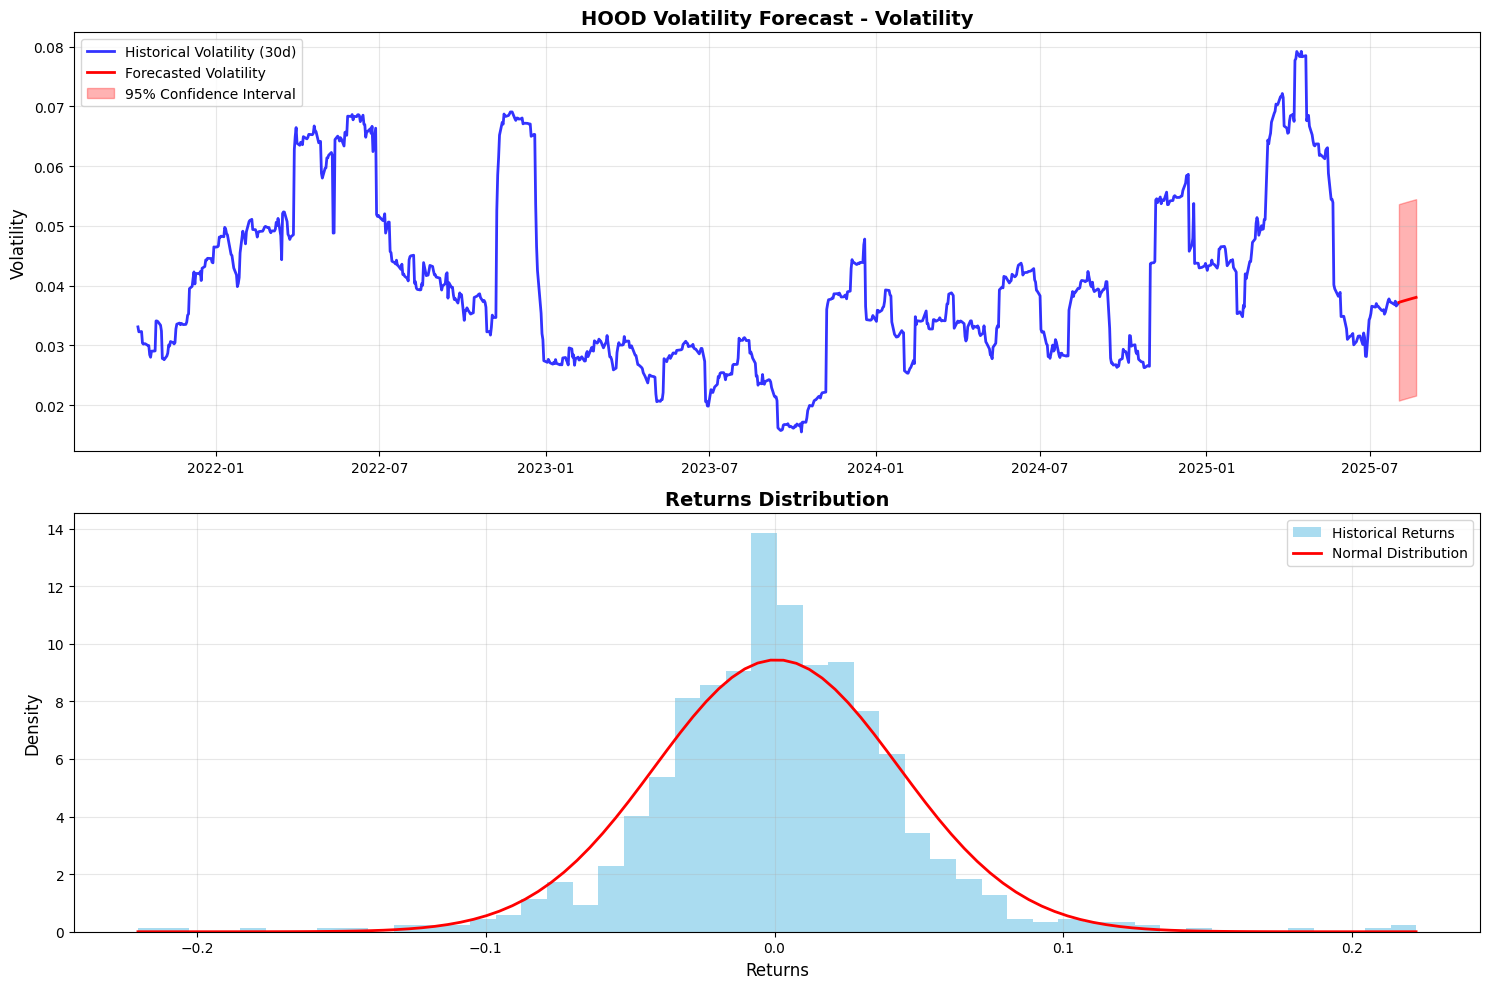

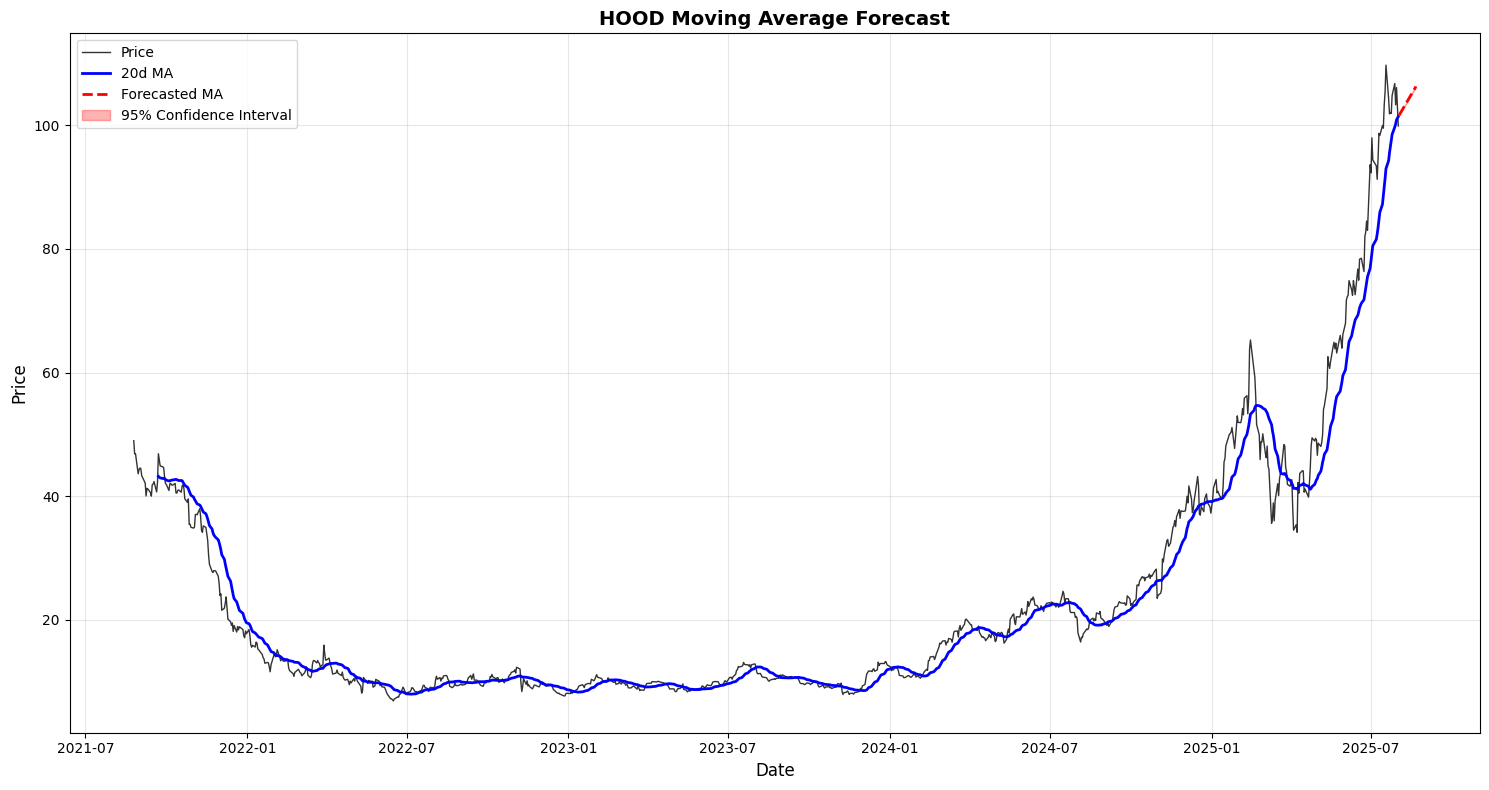


✅ GARCH analysis complete for HOOD!
📊 Variables defined: vol_forecast, ma_forecast, vol_forecast_dict, ma_forecast_dict


In [29]:
# GARCH Volatility Forecasting for Selected Stock
print(f"🔮 Running GARCH volatility analysis for {selected_stock}...")

# Create volatility model (FIXED IMPORTS - NO 'src.' PREFIX)
from models.garch_volatility import create_volatility_model, plot_volatility_forecast, plot_ma_forecast, calculate_returns

forecast_horizon = 20

# Use the selected stock data (CORRECT VARIABLE NAMES)
print(f"Building GARCH volatility model (horizon={forecast_horizon} days)...")
volatility_results = create_volatility_model(
    prices=selected_stock_data['Close'], 
    ma_window=20, 
    forecast_horizon=forecast_horizon
)

print(f"✅ Volatility model type: {volatility_results['model_type']}")
print(f"📊 Current price: ${volatility_results['current_stats']['current_price']:.2f}")
print(f"📈 Current MA: ${volatility_results['current_stats']['current_ma']:.2f}")
print(f"⚡ Current volatility: {volatility_results['current_stats']['current_volatility']:.4f}")
print(f"🎯 Price/MA Ratio: {volatility_results['current_stats']['price_to_ma_ratio']:.3f}")

# Extract forecasts (THESE ARE THE MISSING VARIABLES!)
vol_forecast = volatility_results['volatility_forecast']['volatility_forecast']
ma_forecast = volatility_results['ma_forecast']['ma_forecast']

# Store the complete forecast dictionaries for downstream use
vol_forecast_dict = volatility_results['volatility_forecast']
ma_forecast_dict = volatility_results['ma_forecast']

print(f"\n🔮 Forecasts:")
print(f"  Mean forecasted volatility: {np.mean(vol_forecast):.4f}")
volatility_trend_direction = 'Increasing' if volatility_results['volatility_forecast']['volatility_trend'] > 0 else 'Decreasing'
print(f"  Volatility trend: {volatility_results['volatility_forecast']['volatility_trend']:.4f} ({volatility_trend_direction})")
print(f"  20-day MA forecast (final): ${ma_forecast[-1]:.2f}")

expected_price_change = ((ma_forecast[-1] - current_price) / current_price * 100)
print(f"  Expected price change: {expected_price_change:.2f}%")

# Plot forecasts
returns = calculate_returns(selected_stock_data['Close'], method='log')
plot_volatility_forecast(vol_forecast_dict, returns, title=f"{selected_stock} Volatility Forecast")
plot_ma_forecast(ma_forecast_dict, selected_stock_data['Close'], ma_window=20, title=f"{selected_stock} Moving Average Forecast")

print(f"\n✅ GARCH analysis complete for {selected_stock}!")
print(f"📊 Variables defined: vol_forecast, ma_forecast, vol_forecast_dict, ma_forecast_dict")

In [30]:
# Individual Stock Markov Model Training
print(f"🎲 Training individual Markov model for {selected_stock}...")

# Train stock-specific model using the multi-stock trained global model
stock_specific_markov = MultiStockBBMarkovModel()

# Use same thresholds as global model
stock_specific_markov.parabolic_up_thresh = multi_stock_model.parabolic_up_thresh
stock_specific_markov.strong_up_thresh = multi_stock_model.strong_up_thresh  
stock_specific_markov.up_thresh = multi_stock_model.up_thresh
stock_specific_markov.down_thresh = multi_stock_model.down_thresh
stock_specific_markov.strong_down_thresh = multi_stock_model.strong_down_thresh
stock_specific_markov.parabolic_down_thresh = multi_stock_model.parabolic_down_thresh

# Set global trend priors from the trained global model (CORRECT ATTRIBUTE NAME)
stock_specific_markov.global_trend_priors = multi_stock_model.global_trend_priors.copy()
stock_specific_markov.global_trend_models = multi_stock_model.global_trend_models.copy()

# Fit the individual stock model
stock_specific_markov.fit_stock_models({selected_stock: selected_stock_data})

print(f"✅ Individual model trained with {len(selected_stock_data)} data points")

# Get the stock-specific model info
if selected_stock in stock_specific_markov.stock_models:
    stock_info = stock_specific_markov.stock_models[selected_stock]
    print(f"🎯 Fitted trends for {selected_stock}: {stock_info['fitted_trends']}")
    
    # Get current trend from the data DataFrame (CORRECT ACCESS)
    current_trend_from_data = stock_info['data']['Trend'].iloc[-1]
    print(f"📊 Current trend: {current_trend_from_data}")
    
    # Show state distribution for current trend
    if current_trend_from_data in stock_info['models']:
        current_trend_model = stock_info['models'][current_trend_from_data]
        if hasattr(current_trend_model, 'transition_matrix') and current_trend_model.transition_matrix is not None:
            print(f"🎯 Transition matrix shape: {current_trend_model.transition_matrix.shape}")
        else:
            print(f"⚠️  Using global prior for current trend: {current_trend_from_data}")
    else:
        print(f"⚠️  Current trend {current_trend_from_data} not in fitted models, using global prior")
else:
    print(f"❌ Failed to create stock-specific model for {selected_stock}")
    current_trend_from_data = current_trend  # Fallback to the trend from selected_stock_data

🎲 Training individual Markov model for HOOD...
🏢 Fitting individual stock models with trend-specific priors (α=5.0)...
🔄 Fitting model for HOOD...
  ✅ parabolic_up: 189 observations (Bayesian update)
  ✅ strong_up: 139 observations (Bayesian update)
  ✅ up: 123 observations (Bayesian update)
  ✅ ranging: 102 observations (Bayesian update)
  ✅ down: 140 observations (Bayesian update)
  ✅ strong_down: 182 observations (Bayesian update)
  ✅ parabolic_down: 108 observations (Bayesian update)
✅ HOOD model complete: 7 trend states fitted
🎉 All stock models fitted! Total stocks: 1
✅ Individual model trained with 988 data points
🎯 Fitted trends for HOOD: ['parabolic_up', 'strong_up', 'up', 'ranging', 'down', 'strong_down', 'parabolic_down']
📊 Current trend: strong_up
🎯 Transition matrix shape: (5, 5)


📈 Generating OHLC forecasts for HOOD...
🔄 Fitting down trend model with 443 observations (Bayesian approach)
✅ Fitted down trend model successfully
🔄 Fitting sideways trend model with 44 observations (Bayesian approach)
✅ Fitted sideways trend model successfully
🔄 Fitting up trend model with 477 observations (Bayesian approach)
✅ Fitted up trend model successfully
🎯 Using trend: strong_up for forecasting
✅ Using stock-specific model for strong_up trend
📊 Current state: 2 (Middle)
🎲 Generated BB state sequence: [1 1 3 3 2]... (showing first 5)
✅ OHLC forecasts generated for 20 days
📊 Next day forecast:
  - Open: $99.57
  - High: $101.92
  - Low: $97.36
  - Close: $99.80

📊 CREATING ENHANCED FORECAST DATAFRAME (BUSINESS DAYS ONLY)
📅 Forecast period: 2025-08-04 to 2025-08-29
📈 Business days generated: 20

📊 BUSINESS DAYS FORECAST DATAFRAME
           Day_of_Week   Open   High    Low  Close  Close_CI_Lower  Close_CI_Upper  Running_Max  Running_Min  Daily_Return  Cumulative_Return  Volatili

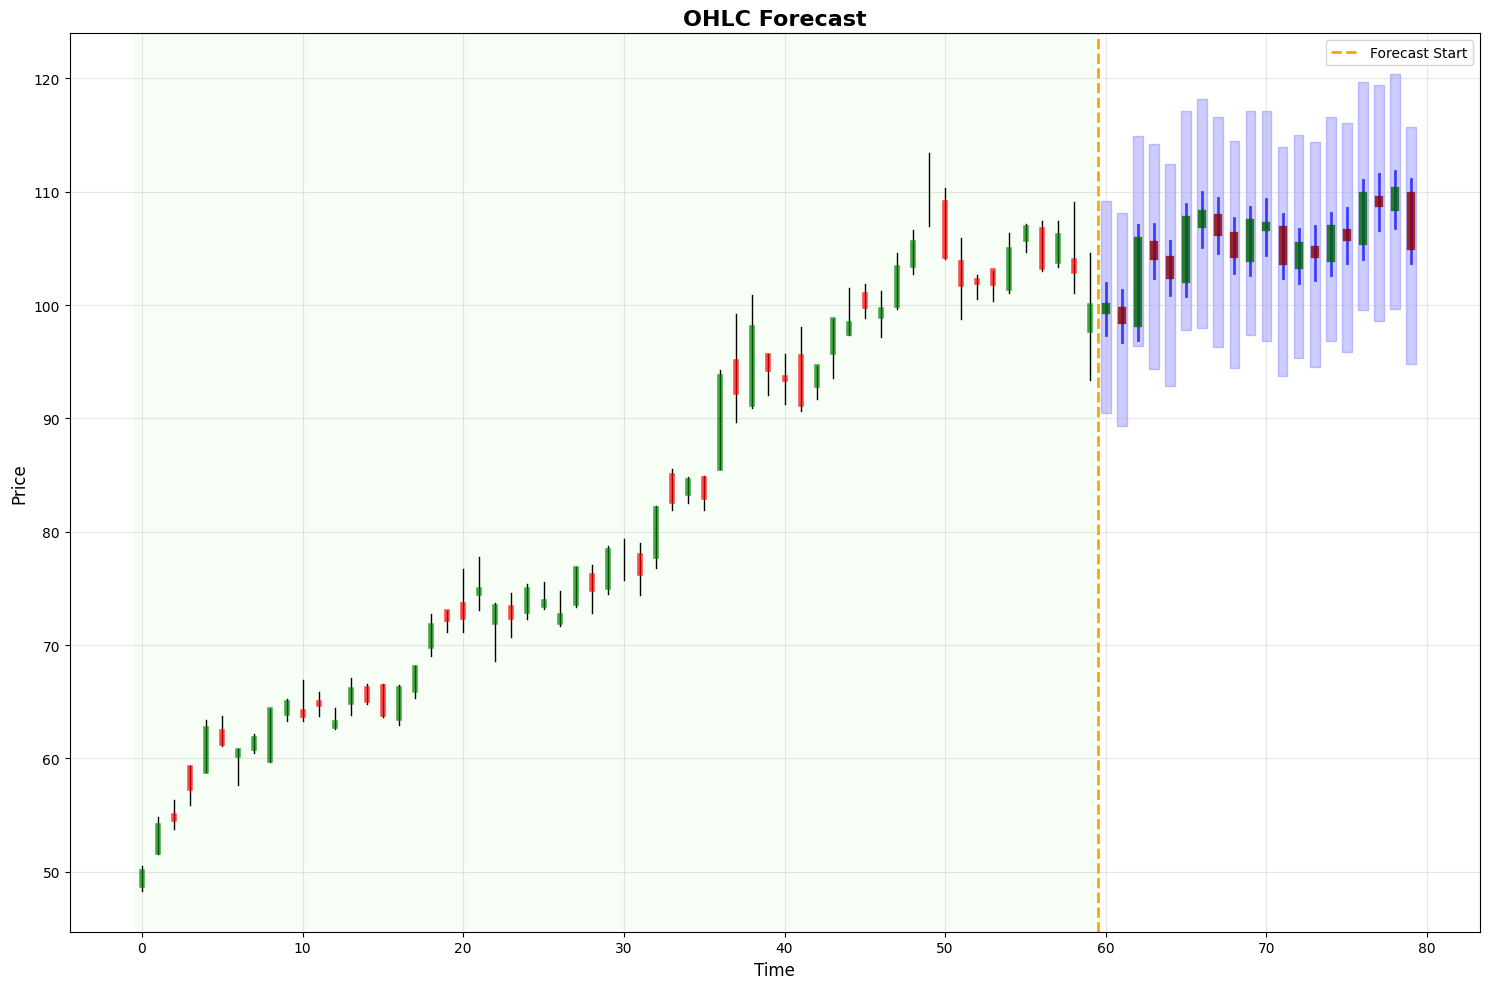


✅ OHLC analysis complete with business days DataFrame and visualization!
📊 Forecast DataFrame stored as 'ohlc_forecast_df' for further analysis


,Open,High,Low,Close,Close_CI_Lower,Close_CI_Upper,High_CI_Lower,High_CI_Upper,Low_CI_Lower,Low_CI_Upper,Running_Max,Running_Min,Range,Body,Daily_Return,Cumulative_Return,Volatility,CI_Width,Day_of_Week
Date,,,,,,,,,,,,,,,,,,,
2025-08-04,99.57,101.92,97.36,99.80,90.44,109.16,100.49,103.34,95.94,98.78,101.92,97.36,4.56,0.23,NaN,-0.10,3.72,18.72,Monday
2025-08-05,99.48,101.32,96.78,98.72,89.37,108.08,99.90,102.73,95.37,98.20,101.92,96.78,4.53,-0.75,-1.08,-1.18,3.72,18.72,Tuesday
2025-08-06,98.40,107.03,96.94,105.67,96.41,114.93,105.58,108.49,95.48,98.39,107.03,96.78,10.09,7.27,7.03,5.78,3.73,18.53,Wednesday
2025-08-07,105.33,107.17,102.37,104.32,94.40,114.25,105.67,108.66,100.88,103.87,107.17,96.78,4.79,-1.00,-1.28,4.43,3.73,19.85,Thursday
2025-08-08,103.98,105.62,100.90,102.64,92.84,112.45,104.15,107.10,99.42,102.37,107.17,96.78,4.72,-1.34,-1.61,2.75,3.74,19.61,Friday
2025-08-11,102.31,108.90,100.80,107.49,97.84,117.15,107.40,110.39,99.31,102.30,108.90,96.78,8.09,5.19,4.73,7.60,3.74,19.31,Monday
2025-08-12,107.14,110.02,105.10,108.08,97.96,118.20,108.48,111.55,103.56,106.63,110.02,96.78,4.92,0.93,0.54,8.19,3.75,20.23,Tuesday
2025-08-13,107.73,109.49,104.59,106.46,96.28,116.64,107.96,111.01,103.06,106.12,110.02,96.78,4.90,-1.27,-1.50,6.56,3.75,20.36,Wednesday
2025-08-14,106.11,107.65,102.84,104.48,94.45,114.51,106.15,109.15,101.33,104.34,110.02,96.78,4.81,-1.63,-1.86,4.58,3.75,20.07,Thursday


In [31]:
# OHLC Forecasting for Selected Stock
print(f"📈 Generating OHLC forecasts for {selected_stock}...")

# Initialize OHLC forecaster (FIXED IMPORTS - NO 'src.' PREFIX)
from models.ohlc_forecasting import OHLCForecaster
ohlc_forecaster = OHLCForecaster(bb_window=20, bb_std=2.0)

# Fit the model
ohlc_forecaster.fit(selected_stock_data[['Open', 'High', 'Low', 'Close']])

# Generate BB state forecasts using the trained model
forecast_days = 20

# Use the current trend from the trained model (CORRECT VARIABLE)
if 'current_trend_from_data' in locals():
    current_trend_str = current_trend_from_data
else:
    current_trend_str = selected_stock_data['Trend'].iloc[-1]

print(f"🎯 Using trend: {current_trend_str} for forecasting")

# Get the appropriate model for forecasting
if selected_stock in stock_specific_markov.stock_models:
    active_model = stock_specific_markov.get_stock_model(selected_stock, current_trend_str)
    print(f"✅ Using stock-specific model for {current_trend_str} trend")
else:
    # Fallback to global model
    active_model = stock_specific_markov.global_trend_models.get(current_trend_str, stock_specific_markov.global_model)
    print(f"⚠️  Using global model for {current_trend_str} trend")

# Get current state
current_state = active_model.get_state_from_bb_position(current_bb_position)
print(f"📊 Current state: {current_state} ({active_model.state_labels[current_state]})")

# Generate state sequence forecast
bb_states = []
current_s = current_state
for _ in range(forecast_days):
    # Sample next state from transition matrix
    if hasattr(active_model, 'transition_matrix') and active_model.transition_matrix is not None:
        probs = active_model.transition_matrix[current_s]
        next_state = np.random.choice(len(probs), p=probs)
    else:
        next_state = current_s  # Stay in current state if no transition matrix
    bb_states.append(next_state)
    current_s = next_state

bb_states = np.array(bb_states)
print(f"🎲 Generated BB state sequence: {bb_states[:5]}... (showing first 5)")

# Generate OHLC forecasts
ohlc_forecast = ohlc_forecaster.forecast_ohlc(
    ma_forecast=ma_forecast,
    vol_forecast=vol_forecast,
    bb_states=bb_states,
    current_close=current_price,
    n_days=forecast_days
)

print(f"✅ OHLC forecasts generated for {len(ohlc_forecast['dates'])} days")
print(f"📊 Next day forecast:")
print(f"  - Open: ${ohlc_forecast['open'][0]:.2f}")
print(f"  - High: ${ohlc_forecast['high'][0]:.2f}")  
print(f"  - Low: ${ohlc_forecast['low'][0]:.2f}")
print(f"  - Close: ${ohlc_forecast['close'][0]:.2f}")

# CREATE BUSINESS DAYS ONLY FORECAST DATAFRAME
print(f"\n📊 CREATING ENHANCED FORECAST DATAFRAME (BUSINESS DAYS ONLY)")
print("=" * 80)

# Generate business days only starting from next business day
from pandas.tseries.offsets import BDay
last_business_day = selected_stock_data.index[-1]
business_dates = pd.date_range(
    start=last_business_day + BDay(1), 
    periods=forecast_days, 
    freq='B'  # Business day frequency
)

print(f"📅 Forecast period: {business_dates[0].strftime('%Y-%m-%d')} to {business_dates[-1].strftime('%Y-%m-%d')}")
print(f"📈 Business days generated: {len(business_dates)}")

# Create the comprehensive forecast DataFrame
forecast_df = pd.DataFrame({
    'Date': business_dates,
    'Open': ohlc_forecast['open'][:len(business_dates)],
    'High': ohlc_forecast['high'][:len(business_dates)],
    'Low': ohlc_forecast['low'][:len(business_dates)],
    'Close': ohlc_forecast['close'][:len(business_dates)],
})

# Add confidence intervals
forecast_df['Close_CI_Lower'] = [ohlc_forecast['close_ci'][i][0] for i in range(len(business_dates))]
forecast_df['Close_CI_Upper'] = [ohlc_forecast['close_ci'][i][1] for i in range(len(business_dates))]
forecast_df['High_CI_Lower'] = [ohlc_forecast['high_ci'][i][0] for i in range(len(business_dates))]
forecast_df['High_CI_Upper'] = [ohlc_forecast['high_ci'][i][1] for i in range(len(business_dates))]
forecast_df['Low_CI_Lower'] = [ohlc_forecast['low_ci'][i][0] for i in range(len(business_dates))]
forecast_df['Low_CI_Upper'] = [ohlc_forecast['low_ci'][i][1] for i in range(len(business_dates))]

# Calculate running max and min
forecast_df['Running_Max'] = forecast_df['High'].cummax()
forecast_df['Running_Min'] = forecast_df['Low'].cummin()

# Calculate additional metrics
forecast_df['Range'] = forecast_df['High'] - forecast_df['Low']
forecast_df['Body'] = forecast_df['Close'] - forecast_df['Open']
forecast_df['Daily_Return'] = forecast_df['Close'].pct_change() * 100
forecast_df['Cumulative_Return'] = ((forecast_df['Close'] / current_price) - 1) * 100
forecast_df['Volatility'] = vol_forecast[:len(business_dates)] * 100  # Convert to percentage

# Add confidence interval width
forecast_df['CI_Width'] = forecast_df['Close_CI_Upper'] - forecast_df['Close_CI_Lower']

# Add day of week for reference
forecast_df['Day_of_Week'] = forecast_df['Date'].dt.strftime('%A')

# Set Date as index for better display
forecast_df.set_index('Date', inplace=True)

# Round all numeric columns for clean display
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Close_CI_Lower', 'Close_CI_Upper', 
                  'High_CI_Lower', 'High_CI_Upper', 'Low_CI_Lower', 'Low_CI_Upper',
                  'Running_Max', 'Running_Min', 'Range', 'Body', 'CI_Width']
for col in numeric_columns:
    if col in forecast_df.columns:
        forecast_df[col] = forecast_df[col].round(2)

percentage_columns = ['Daily_Return', 'Cumulative_Return', 'Volatility']
for col in percentage_columns:
    if col in forecast_df.columns:
        forecast_df[col] = forecast_df[col].round(2)

# Display the main forecast DataFrame
print(f"\n📊 BUSINESS DAYS FORECAST DATAFRAME")
print("=" * 120)

# Select key columns for primary display
display_df = forecast_df[['Day_of_Week', 'Open', 'High', 'Low', 'Close', 
                         'Close_CI_Lower', 'Close_CI_Upper', 'Running_Max', 'Running_Min',
                         'Daily_Return', 'Cumulative_Return', 'Volatility']].copy()

print(display_df.to_string(float_format='%.2f'))

# Additional detailed table with confidence intervals
print(f"\n📊 DETAILED CONFIDENCE INTERVALS TABLE")
print("=" * 100)
ci_df = forecast_df[['Day_of_Week', 'Close', 'Close_CI_Lower', 'Close_CI_Upper', 'CI_Width',
                    'High_CI_Lower', 'High_CI_Upper', 'Low_CI_Lower', 'Low_CI_Upper']].copy()
print(ci_df.to_string(float_format='%.2f'))

# Summary statistics
print(f"\n📈 FORECAST SUMMARY STATISTICS")
print("=" * 60)
print(f"🎯 Current Price:        ${current_price:.2f}")
print(f"📊 Final Forecast:       ${forecast_df['Close'].iloc[-1]:.2f}")
print(f"🚀 Maximum High:         ${forecast_df['Running_Max'].iloc[-1]:.2f}")
print(f"📉 Minimum Low:          ${forecast_df['Running_Min'].iloc[-1]:.2f}")
print(f"📈 Total Return:         {forecast_df['Cumulative_Return'].iloc[-1]:.2f}%")
print(f"⚡ Avg Volatility:       {forecast_df['Volatility'].mean():.2f}%")
print(f"📊 Avg Daily Range:      ${forecast_df['Range'].mean():.2f}")
print(f"🎯 Avg CI Width:         ${forecast_df['CI_Width'].mean():.2f}")
print(f"📊 Max CI Width:         ${forecast_df['CI_Width'].max():.2f}")
print(f"📅 Business Days:        {len(forecast_df)}")
print(f"📅 Calendar Days Span:   {(business_dates[-1] - business_dates[0]).days + 1}")

# Store the forecast DataFrame for downstream use
ohlc_forecast_df = forecast_df.copy()

# RESTORE OHLC FORECAST VISUALIZATION
print(f"\n📊 Plotting OHLC forecast visualization...")
ohlc_forecaster.plot_ohlc_forecast(ohlc_forecast, n_historical=60)

print(f"\n✅ OHLC analysis complete with business days DataFrame and visualization!")
print(f"📊 Forecast DataFrame stored as 'ohlc_forecast_df' for further analysis")
ohlc_forecast_df

In [32]:
# Options Strategy Recommendations
print(f"📋 Generating options strategy recommendations for {selected_stock}...")

# Calculate expected price movement
expected_close = ohlc_forecast['close'][19]  # 20-day forecast
expected_return = (expected_close - current_price) / current_price
expected_volatility = np.mean(vol_forecast)

print(f"📊 20-day price forecast: ${expected_close:.2f}")
print(f"📈 Expected return: {expected_return:.2%}")
print(f"⚡ Expected volatility: {expected_volatility:.4f}")

# Use the correct trend variable
active_trend = current_trend_str if 'current_trend_str' in locals() else current_trend
print(f"🎯 Current trend context: {active_trend}")

# Determine optimal options strategy
if expected_return > 0.05:  # Strong bullish
    if expected_volatility > current_bb_width:
        strategy = "Long Call + Long Put (Long Straddle)"
        reason = f"Strong bullish bias ({expected_return:.1%}) with increasing volatility in {active_trend} trend"
    else:
        strategy = "Long Call"
        reason = f"Strong bullish bias ({expected_return:.1%}) with stable volatility in {active_trend} trend"
elif expected_return < -0.05:  # Strong bearish
    if expected_volatility > current_bb_width:
        strategy = "Long Put + Long Call (Long Straddle)"
        reason = f"Strong bearish bias ({expected_return:.1%}) with increasing volatility in {active_trend} trend"
    else:
        strategy = "Long Put"
        reason = f"Strong bearish bias ({expected_return:.1%}) with stable volatility in {active_trend} trend"
else:  # Neutral/range-bound
    if expected_volatility > current_bb_width:
        strategy = "Long Straddle"
        reason = f"Neutral bias ({expected_return:.1%}) with increasing volatility in {active_trend} trend"
    else:
        strategy = "Iron Condor / Short Straddle"
        reason = f"Neutral bias ({expected_return:.1%}) with decreasing volatility in {active_trend} trend"

print(f"\n🎯 RECOMMENDED STRATEGY: {strategy}")
print(f"💡 Reasoning: {reason}")

# Calculate key levels
support_level = min(ohlc_forecast['low'])
resistance_level = max(ohlc_forecast['high'])
target_price = expected_close

print(f"\n📊 KEY LEVELS:")
print(f"  Support: ${support_level:.2f}")
print(f"  Resistance: ${resistance_level:.2f}")
print(f"  Target: ${target_price:.2f}")
print(f"  Current: ${current_price:.2f}")

# Risk metrics
max_upside = (resistance_level - current_price) / current_price
max_downside = (current_price - support_level) / current_price

print(f"\n⚠️ RISK METRICS:")
print(f"  Max upside: {max_upside:.2%}")
print(f"  Max downside: {max_downside:.2%}")
print(f"  Risk/Reward: {max_downside/max_upside:.2f}")

# Additional trend-based insights
trend_insights = {
    'parabolic_up': "⚠️ Extreme bullish momentum - consider profit-taking levels",
    'strong_up': "📈 Strong uptrend - momentum strategies favored", 
    'up': "🔼 Moderate uptrend - balanced approach recommended",
    'ranging': "↔️ Sideways market - volatility strategies preferred",
    'down': "🔽 Moderate downtrend - defensive strategies recommended",
    'strong_down': "📉 Strong downtrend - bear strategies favored",
    'parabolic_down': "⚠️ Extreme bearish momentum - consider protective strategies"
}

if active_trend in trend_insights:
    print(f"\n💡 TREND INSIGHT: {trend_insights[active_trend]}")

print(f"\n✅ Analysis complete for {selected_stock}!")
print("=" * 60)

📋 Generating options strategy recommendations for HOOD...
📊 20-day price forecast: $105.24
📈 Expected return: 5.35%
⚡ Expected volatility: 0.0376
🎯 Current trend context: strong_up

🎯 RECOMMENDED STRATEGY: Long Call
💡 Reasoning: Strong bullish bias (5.3%) with stable volatility in strong_up trend

📊 KEY LEVELS:
  Support: $96.78
  Resistance: $111.80
  Target: $105.24
  Current: $99.90

⚠️ RISK METRICS:
  Max upside: 11.91%
  Max downside: 3.12%
  Risk/Reward: 0.26

💡 TREND INSIGHT: 📈 Strong uptrend - momentum strategies favored

✅ Analysis complete for HOOD!


In [33]:
# CLEANED UP - Duplicate OHLC cell removed (analysis in cell-16)

In [ ]:
# CLEANED UP - Duplicate Options cell removed (analysis in cell-17)

In [ ]:
# CLEANED UP - This section header removed

In [ ]:
# CLEANED UP - This section header removed

In [ ]:
# CLEANED UP - This section header removed

In [ ]:
# CLEANED UP - This section header removed

In [ ]:
# CLEANED UP - This section header removed

In [ ]:
# CLEANED UP - This section header removed

In [ ]:
# CLEANED UP - This section header removed

In [ ]:
# CLEANED UP - This section header removed

In [ ]:
# CLEANED UP - Duplicate analysis cell removed (moved to cell-17)

In [ ]:
# CLEANED UP - Duplicate OHLC cell removed (moved to cell-16)

In [ ]:
# CLEANED UP - Duplicate Markov analysis cell removed (integrated into cell-15)

In [ ]:
# CLEANED UP - Placeholder cell removed

In [ ]:
# CLEANED UP - Duplicate stock selection cell removed (kept cell-13)

In [ ]:
# Summary and Next Steps
print("🎉 INDIVIDUAL STOCK ANALYSIS COMPLETE!")
print("=" * 60)
print(f"📊 Analysis completed for: {selected_stock}")
print(f"🔮 Forecasting horizon: {forecast_days} days")
print(f"🎯 Current trend: {current_trend_str if 'current_trend_str' in locals() else 'N/A'}")
print(f"💰 Current price: ${current_price:.2f}")
print(f"📈 Forecasted price: ${ohlc_forecast['close'][-1] if 'ohlc_forecast' in locals() else 'N/A'}")

print(f"\n🔄 To analyze a different stock:")
print(f"  1. Change 'selected_stock' variable in the stock selection cell")
print(f"  2. Re-run cells 13-17 for complete analysis")
print(f"  3. Get fresh GARCH, Markov, OHLC, and options analysis!")

print(f"\n📋 Components completed:")
print(f"  ✅ Stock Selection & Data Preparation")
print(f"  ✅ GARCH Volatility Forecasting")  
print(f"  ✅ Individual Markov Model Training")
print(f"  ✅ OHLC Price Forecasting")
print(f"  ✅ Options Strategy Recommendations")

if 'strategy' in locals():
    print(f"\n🎯 Recommended Strategy: {strategy}")
    
print(f"\n🌍 Global model trained on {len(all_stock_bb_data)} stocks")
print(f"📊 7-trend classification with enhanced sensitivity")
print(f"🚀 Ready for options trading decisions!")

In [ ]:
# CLEANED UP - Documentation cell removed